# 8. 임베딩 내 편향성 알아보기

8-1. 들어가며<br>
8-2. 워드 임베딩의 편향성<br>
8-3. WEAT를 통한 편향성 측정<br>
8-4. WEAT 구현하기<br>
8-5. 사전학습된 Word Embedding에 WEAT 적용<br>
8-6. 직접 만드는 Word Embedding에 WEAT 적용(1)<br>
8-7. 직접 만드는 Word Embedding에 WEAT 적용(2)

## 8-1. 들어가며
---
### 학습 목표

- 데이터의 편향성에 대한 문제의식을 무엇인지 설명할 수 있습니다.
- `WEAT(Word Embedding Association Test)`에 대해서 설명할 수 있습니다.
- WEAT 수식의 의미를 이해하고 이를 구현할 수 있습니다.
- pre-train된 모델을 불러와서 `WEAT score`를 구현할 수 있습니다.

### 인공지능은 객관적일까?
---
학습 데이터의 편향성

예시:
- 차량 충돌 사고실험 : 남성위주 데이터 사용
    - 한 데이터 제조업체에서 충돌 실험을 통해 탑승자의 신체 움직임을 파악하고 안전성을 높이고자 했습니다. 그러나 결과적으로 여성 탑승자가 남성 탑승자보다 사망률이 높았다
- 아마존 인공지능 채용 시스템 : 성 차별적 특성
    - '여성'이라는 단어가 포함되면 감점
    - 여자 대학을 졸업한 지원자의 점수가 감점
    - 지난 10년간의 회사에 제출된 이력서 패턴을 익힌 인공지능 채용 시스템은 남성 우위인 기술산업 업계의 현실을 반영
- 콤파스 : 범죄자의 형량을 정하는 알고리즘 : 인종차별적 특성
    - 이 알고리즘은 범죄 방식, 생활 방식, 성격, 태도 등의 점수를 환산해 범죄자의 재범률을 예측하는 시스템
    - 인종을 변수로 포함하고 있지 않은데도 흑인의 재범 가능성을 백인보다 2배 위험하다고 판단
    - 흑인과 백인은 동일 범행에 대해 다른 처벌을 받았기 때문에 이런 결과가 나타난 것
    - 재범을 저지른 흑인은 체포될 확률이 백인에 비해 높았기 때문에 이런 데이터로 학습한 콤파스는 인종 차별을 할 수 밖에 없었습니다.

### "<u>데이터 안에 이미 편향성이 내재되어 있다면 이를 통해 나온 결과도 편향성을 가질 수 밖에 없다</u>"

<br>

최근에는 **인공지능이 가진 편향성을 예방하기 위한 연구**가 지속되고 있습니다. 
- 특히 자연어처리 분야, 
- 그중에서도 워드 임베딩과 관련된 연구

#### 자연어 처리, 워드 임베딩에서 편향성 예방 연구 이유:
1. 언어의 사용패턴이 담긴 코퍼스야말로 인간 무의식 속에 감추어진 편향성이 고스란히 드러나는 데이터셋
2. 그 언어의 의미가 워드 임베딩에 추상적인 형태로 담겨 있는데, 
    - 최근 연구를 통해 그 **임베딩 공간에서 편향성을 정량적으로 측정하는 방법론**들이 발표되면서 이 분야의 연구가 활기를 띠게 되었기 때문

<br>

그래서 오늘은 **워드 임베딩에 숨어 있는 편향성을 측정하는 대표적인 방법론**인 :
### "Word Embedding Association Test (WEAT)" 
라는 기법에 대해 알아보고, 

이를 활용해 우리가 학습시킨 **Word2Vec 임베딩 내의 편향성을 측정**해 보면서 

실제로 이 방법론이 우리 머리 속에 있는 편향성을 잘 반영하는지도 살펴보겠습니다.









학습 내용<br>

>4-2 워드 임베딩의 편향성 : 워드 임베딩의 편향성이 무엇인지 학습니다.<br>
4-3 WEAT를 통한 편향성 측정 : WEAT를 통한 편향성 측정을 학습합니다.<br>
4-4 WEAT 구현하기 : WEAT score를 코드로 구현합니다.<br>
4-5 사전학습된 Word Embedding에 WEAT 적용 : target, attribute 셋을 만들어서 WEAT score를 구현합니다.<br>
4-6 직접 만드는 Word Embedding에 WEAT 적용(1) : 주어진 데이터를 활용해 WEAT score를 코드로 구현합니다.<br>
4-7 직접 만드는 Word Embedding에 WEAT 적용(2) : 주어진 데이터를 활용해 WEAT score를 코드로 구현합니다.



## 8-2. 워드 임베딩의 편향성

[Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings](https://arxiv.org/pdf/1607.06520.pdf)<br>
 : 우리가 가지고 있을지도 모를 편견이 워드 임베딩 속 벡터들에 고스란히 반영되어 있었다는 것을 보여 준 논문
 

### WEAT(Word Embedding Association Test)

워드 임베딩 벡터들 간에는 **의미적인 유사도 거리를 정량적으로 측정**할 수 있습니다. 그렇다면 워드 임베딩에 **내포된 편향성도 정량적으로 측정할 방법**은 없을까요? 위 논문이 발표되자마자 몇 달도 되지 않아 그런 방법이 제안되었습니다.

Word Embedding Association Test (WEAT) 논문 : 
- [Semantics derived automatically from language corpora necessarily contain human biases](https://arxiv.org/pdf/1608.07187.pdf)


- 워드 임베딩에 편향성이 반영되어 있다는 것을 발견
- 워드 임베딩 벡터의 `의미적 유사도`를 정량적으로 측정 가능 -> 그럼 임베딩에 내포된 `편향성`도 정량적으로 측정할 수 있지 않을까?
- 워드 임베딩의 편향성을 정량적으로 측정할 방법을 제시 : **"`WEAT`"**


#### WEAT(Word Embedding Association Test)? : 

- `target` : 분석하고자 하는 개념이나 집단을 대표하는 단어들의 집합
    - 편향성이 있는지 알아보려는 단어 셋
- `attribute` : 특정 속성이나 개념을 대표하는 단어들의 집합
    - 편향성을 따질 기준 단어 셋

target 단어와 attribute 단어들의 거리를 통해 편향성을 측정하는 방법
> 예를들어, 
>- science/art : target
>- male/female : attribute<br>
>WEAT score의 절대값이 클 수록 편향성도 큼

## 8-3. WEAT를 통한 편향성 측정
### WEAT score
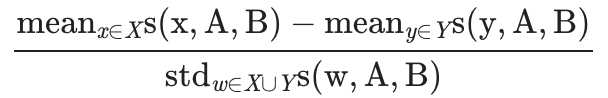
- X, Y : target
- A, B : attribute
    - (X, Y, A, B : 단어벡터들의 집합)
- `s(w, A, B) = mean cos(w, a) - mean cos(w, b)`, w, a, b : vector


- 벡터의 유사도 측정을 위해 cosine similarity 사용
- `s(w, A, B)` : target set의 단어 `w`가 두 attribute set A, B에 속한 단어들과의 유사도의 평균(mean)값이 얼마나 차이나는지 측정

    - == `w`가 `개념축 A-B`에 대해 가지는 편향성을 계산한 값 `(-2, 2)`
    - 절대값이 클 수록 w 가 A-B 개념축에 대해 편향성을 가진다는 의미
    
- 분자 부분 : target X, Y에 속하는 단어 x, y들이 개념축 A-B에 대해 가지는 편향성을 각각 **평균**내서 **뺀** 값
    - X에 속하는 단어들과 Y에 속하는 단어들이 A-B 개념축에 대해 가지는 편향성의 정도가 뚜렷할 수록 
    - WEAT score 식의 `abs(분자값)`이 커짐
- 분모 부분 : X, Y에 속하는 모든 단어들이 가지는 **편향성 값의 표준편차(std)**로 **normalize**
    - 한 값이 최종 WEAT score가 됩니다.

## 8-4. WEAT 구현하기



In [1]:
# 라이브러리 import
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [2]:
# 두 개의 target 단어 셋 X, Y와 두 개의 attribute 단어 셋 A, B를 정의
'''
targets
    X set(꽃) : 장미, 튤립, 백합, 데이지
    Y set(곤충) : 거미, 모기, 파리, 메뚜기

attributes
    A set(유쾌) : 사랑, 행복, 웃음
    B set(불쾌) : 재난, 고통, 증오
'''


# 위에서 정의한 집합의 임베딩 결과(임베딩 과정은 생략) : 

target_X = {
    '장미': [4.1, 1.2, -2.4, 0.5, 4.1],
    '튤립': [3.1, 0.5, 3.6, 1.7, 5.8],
    '백합': [2.9, -1.3, 0.4, 1.1, 3.7],
    '데이지': [5.4, 2.5, 4.6, -1.0, 3.6]
}
target_Y = {
    '거미': [-1.5, 0.2, -0.6, -4.6, -5.3],
    '모기': [0.4, 0.7, -1.9, -4.5, -2.9],
    '파리': [0.9, 1.4, -2.3, -3.9, -4.7],
    '메뚜기': [0.7, 0.9, -0.4, -4.1, -3.9]
}
attribute_A = {
    '사랑':[2.8,  4.2, 4.3,  0.3, 5.0],
    '행복':[3.8,  3. , -1.2,  4.4, 4.9],
    '웃음':[3.7, -0.3,  1.2, -2.5, 3.9]
}
attribute_B = {
    '재난': [-0.2, -2.8, -4.7, -4.3, -4.7],
    '고통': [-4.5, -2.1,  -3.8, -3.6, -3.1],
    '증오': [-3.6, -3.3, -3.5,  -3.7, -4.4]
}


In [3]:
# 단어 set들을 array로 변환
X = np.array([v for v in target_X.values()])
Y = np.array([v for v in target_Y.values()])
A = np.array([v for v in attribute_A.values()])
B = np.array([v for v in attribute_B.values()])
print(X)
print(Y)
print(A)
print(B)

[[ 4.1  1.2 -2.4  0.5  4.1]
 [ 3.1  0.5  3.6  1.7  5.8]
 [ 2.9 -1.3  0.4  1.1  3.7]
 [ 5.4  2.5  4.6 -1.   3.6]]
[[-1.5  0.2 -0.6 -4.6 -5.3]
 [ 0.4  0.7 -1.9 -4.5 -2.9]
 [ 0.9  1.4 -2.3 -3.9 -4.7]
 [ 0.7  0.9 -0.4 -4.1 -3.9]]
[[ 2.8  4.2  4.3  0.3  5. ]
 [ 3.8  3.  -1.2  4.4  4.9]
 [ 3.7 -0.3  1.2 -2.5  3.9]]
[[-0.2 -2.8 -4.7 -4.3 -4.7]
 [-4.5 -2.1 -3.8 -3.6 -3.1]
 [-3.6 -3.3 -3.5 -3.7 -4.4]]


In [6]:
# s('장미', A, B) 계산 : 

def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

print(s(target_X['장미'], A, B)) # 유쾌 (score > 0)
print(s(target_Y['거미'], A, B)) # 불쾌 (score < 0) ,,, nomalize는 아직 안해줌

0.6457646122337399
-0.794002342033094


In [7]:
# target_X와 attribute_A, attribute_B 사의의 평균값
# target_Y와 attribute_A, attribute_B 사의의 평균값

print(s(X, A, B))
print(round(np.mean(s(X, A, B)), 3))
print('\n')
print(s(Y, A, B))
print(round(np.mean(s(Y, A, B)), 3))

[0.29551989 0.51723181 0.26499096 0.50924109]
0.397


[-0.44713039 -0.28310853 -0.33144878 -0.26030641]
-0.33


In [8]:
# WEAT score의 수식 전체를 코드로
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

print(round(weat_score(X, Y, A, B), 3))

1.932


WEAT score가 매우 높게 나온 것을 알 수 있습니다. 즉, 꽃은 유쾌한 단어와 상대적으로 가깝고, 곤충은 불쾌한 단어와 가깝다는 것을 수치적으로 확인할 수 있었습니다.

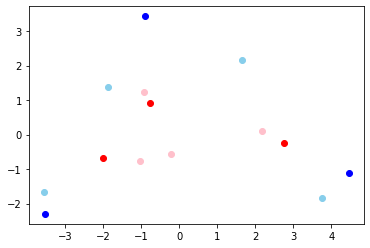

In [9]:
# 시각적으로 확인 : PCA를 통해 5차원이었던 벡터를 2차원으로

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(pc_A[:,0],pc_A[:,1], c='blue', label='A')
ax.scatter(pc_B[:,0],pc_B[:,1], c='red', label='B')
ax.scatter(pc_X[:,0],pc_X[:,1], c='skyblue', label='X')
ax.scatter(pc_Y[:,0],pc_Y[:,1], c='pink', label='Y')

파란색 점(A)과 하늘색 점(X)이 가깝고, 빨간색 점(B)과 분홍색 점(Y)이 가깝게 표현

## 8-5. 사전학습된 Word Embedding에 WEAT 적용

지금까지 WEAT가 어떻게 계산되는지 확인해보았습니다. 이제 **실제 pretrain된 임베딩 모델**을 이용하여 계산해볼까요?

구글에서 학습한 모델을 사용해보도록 하겠습니다.

우선 ~/aiffel/weat 폴더를 만들고 링크를 걸어 줍니다. 압축을 풀면 대략 3G 정도 됩니다. (아래 링크에서 다운받아 로컬에서도 확인해볼수 있습니다.)

[GoogleNews-vectors-negative300.bin.gz](https://drive.google.com/u/0/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download)



In [10]:
!mkdir -p ~/aiffel/weat
!ln -s ~/data/* ~/aiffel/weat/
!cd ~/aiffel/weat
!ls -l

total 13624
-rw-r--r-- 1 root root  1163767 Jan  4 16:33 '7. 워드 임베딩.ipynb'
-rw-r--r-- 1 root root    48800 Jan  7 09:16 '8. 임베딩 내 편향성 알아보기.ipynb'
-rw-r--r-- 1 root root      747 Jan  3 09:24 '9. [프로젝트] 임베딩 내 편향성 알아보기_tmp.ipynb'
-rw-r--r-- 1 root root   294256 Jan  4 16:32 'note 7.ipynb'
-rw-r--r-- 1 root root    81442 Jan  4 16:17  w2v_metadata.tsv
-rw-r--r-- 1 root root 12350785 Jan  4 16:17  w2v_tensor.tsv


In [11]:
# 다음 코드에서 data_dir 변수에 본인의 경로를 잘 설정해서 모델을 불러오도록 합니다.

import os

data_dir = '~/aiffel/weat' 
model_dir = os.path.join(data_dir, 'GoogleNews-vectors-negative300.bin')

from gensim.models import KeyedVectors

# 50만개의 단어만 활용합니다. 메모리가 충분하다면 limit 파라미터값을 생략하여 300만개를 모두 활용할 수 있습니다. 
w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True, limit=500000)

In [13]:
# w2v에 있는 단어 개수와 벡터 크기 확인

# print(len(w2v.vocab))        # Gensim 3.X 버전까지는 w2v.vocab을 직접 접근할 수 있습니다. 
print(len(w2v.index_to_key))   # Gensim 4.0부터는 index_to_key를 활용해 vocab size를 알 수 있습니다. 
print(len(w2v['I']))                    # 혹은 단어를 key로 직접 vector를 얻을 수 있습니다. 
print(w2v.vectors.shape)

500000
300
(500000, 300)


w2v에는 limit으로 지정한 갯수(디폴트는 3,000,000개)의 단어가 있고, **각 단어는 300차원**을 갖는다는 것을 알 수 있습니다.

In [14]:
w2v['happy']

array([-5.18798828e-04,  1.60156250e-01,  1.60980225e-03,  2.53906250e-02,
        9.91210938e-02, -8.59375000e-02,  3.24218750e-01, -2.17285156e-02,
        1.34765625e-01,  1.10351562e-01, -1.04980469e-01, -2.90527344e-02,
       -2.38037109e-02, -4.02832031e-02, -3.68652344e-02,  2.32421875e-01,
        3.20312500e-01,  1.01074219e-01,  5.83496094e-02, -2.91824341e-04,
       -3.29589844e-02,  2.11914062e-01,  4.32128906e-02, -8.59375000e-02,
        2.81250000e-01, -1.78222656e-02,  3.79943848e-03, -1.71875000e-01,
        2.06054688e-01, -1.85546875e-01,  3.73535156e-02, -1.21459961e-02,
        2.04101562e-01, -3.80859375e-02,  3.61328125e-02, -8.15429688e-02,
        8.44726562e-02,  9.37500000e-02,  1.44531250e-01,  7.42187500e-02,
        2.51953125e-01, -7.91015625e-02,  8.69140625e-02,  1.58691406e-02,
        1.09375000e-01, -2.23632812e-01, -5.15747070e-03,  1.68945312e-01,
       -1.36718750e-01, -2.51464844e-02, -3.85742188e-02, -1.33056641e-02,
        1.38671875e-01,  

In [15]:
# 'happy'와 가장 유사한 단어
w2v.most_similar(positive=['happy'])

[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665286064148)]

In [16]:
# WEAT를 통해 이 "모델의 편향성"을 확인해보도록 하겠습니다. 논문에 있던 단어 셋으로 구성

target_X = ['science', 'technology', 'physics', 'chemistry', 'Einstein', 'NASA', 'experiment', 'astronomy']
target_Y = ['poetry', 'art', 'Shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']
attribute_A = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
attribute_B = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.2624874

 -> "모델 자체(GoogleNews-vectors-negative300.bin)"의 편향성 : 1.26...

과학과 관련된 단어가 남성과 관련된 단어와 가깝고, 예술과 관련된 단어가 여성과 관련된 단어와 가깝게 나타났습니다. 사람의 편향성을 실험하는 IAT에서도 이와 같게 나타났었죠? 많은 사람이 가진 편향이 임베딩 모델에 반영되었다고 볼 수 있습니다.

이제 다른 셋을 구성해볼까요? 
- target_X는 인스턴트 식품들로 단어를 구성하였고 
- target_Y는 그 반대로 구성했습니다. 
- attribute_A는 인스턴트를 의미하는 단어들로, 
- attributes_B는 그 반대로 구성했습니다.

이 단어 셋들을 보면 target_X는 attribute_A와 attribute_B 중 어떤 것과 가깝다고 생각하시나요?
보통 target_X와 attribute_A가 가깝고, traget_Y는 attribute_B와 가깝다고 대답할 것입니다.
임베딩 모델도 그렇게 생각할까요?

In [17]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['junk', 'canned', 'convenience', 'frozen', 'fast']
attribute_B = ['health', 'beneficial', 'good', 'nourishing', 'nutritious']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B) # 양수... X가 A에 가깝다.. 음수면 X가 B에 가깝다,,, 로 ...

1.6909266

In [18]:
weat_score(Y, X, A, B)

-1.6909268

In [19]:
# 메모리 비우기
del w2v
print("삭제 완료")

삭제 완료


## 8-6. 직접 만드는 Word Embedding에 WEAT 적용(1)

## 8-7. 직접 만드는 Word Embedding에 WEAT 적용(2)
